In [90]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader

In [91]:
import warnings

from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [92]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm._tqdm_notebook import tqdm
tqdm_notebook.pandas()

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [93]:
FETCH_BACKUP = True

## Load train, test sets, idx's

In [94]:
import pickle

def load_pickle(dataset, name):
    dataset.to_pickle(name + '.pkl')

def from_pickle(path):
    with open(path, 'rb') as reader:
        return pickle.load(reader)

In [95]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
]

df_provider = DatasetProvider()
df_provider.file_list = dataset_paths
datasets = df_provider.get_dataset()

In [96]:
task_df = {}

task_df['test'] = from_pickle('tmp/task_df_test.pkl')
task_df['train'] = from_pickle('tmp/task_df_train.pkl')
task_df['idx'] = from_pickle('tmp/idx.pkl')

In [97]:
MAP = datasets['test.csv'].merge(
    task_df['idx'][['shop_id', 'item_id', 'id']],
    on=['shop_id', 'item_id'],
    how='left'
)

In [98]:
MAP

,ID,shop_id,item_id,id
0,0,5,5037,485225
1,1,5,5320,364565
2,2,5,5233,486065
3,3,5,5232,566225
4,4,5,5268,1074185
...,...,...,...,...
214195,214195,45,18454,451545
214196,214196,45,16188,1211325
214197,214197,45,15757,435525
214198,214198,45,19648,260805


In [99]:
baseline_train = from_pickle('tmp/baseline_model_training_set.pkl')
validation_set = from_pickle('tmp/baseline_model_tuning_set.pkl')
test_set = from_pickle('tmp/baseline_model_validation_set.pkl')
submition_set = from_pickle('tmp/baseline_submission_set.pkl')

In [100]:
for key in baseline_train:
    if not key in ['target', 'lags', 'acf_lags']:
        baseline_train[key].columns = [f'{key}_{agg_type}' for agg_type in baseline_train[key].columns.values]
        validation_set[key].columns = [f'{key}_{agg_type}' for agg_type in validation_set[key].columns.values]
        submition_set[key].columns = [f'{key}_{agg_type}' for agg_type in submition_set[key].columns.values]
        test_set[key].columns = [f'{key}_{agg_type}' for agg_type in test_set[key].columns.values]

In [101]:
full_train = pd.concat(baseline_train.values(), axis=1, join='inner')
full_test = pd.concat(validation_set.values(), axis=1, join='inner')
full_eval = pd.concat(test_set.values(), axis=1, join='inner')
full_submition = pd.concat(submition_set.values(), axis=1, join='inner')

In [102]:
train_x = full_train.drop(['target'], axis=1)
train_y = full_train.loc[:, ['target']]

test_x = full_test.drop(['target'], axis=1)
test_y = full_test.loc[:, ['target']]

eval_x = full_eval.drop(['target'], axis=1)
eval_y = full_eval.loc[:, ['target']]

## Linear model preprocessing

In [103]:
def make_scaled(df_origin):
    def standartize(dataset):
        scaler = StandardScaler()
        try:
            return scaler.fit_transform(dataset.to_numpy())
        except:
            return scaler.fit_transform(dataset)

    df = pd.DataFrame(
        data=standartize(df_origin), 
        index=df_origin.index, 
        columns=df_origin.columns
    )
    return df

In [104]:
train_x = make_scaled(train_x)
test_x = make_scaled(test_x)
eval_x = make_scaled(eval_x)
full_submition = make_scaled(full_submition)

## Feature evaluation

In [105]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

if not FETCH_BACKUP:
    evaluation_forest = RandomForestRegressor(n_jobs=-1, max_depth=400)
    evaluation_forest.fit(train_x, train_y)
    with open('tmp/baseline_rfr.pkl', 'wb+') as writer:
        pickle.dump(evaluation_forest, writer)
else:
    evaluation_forest = from_pickle('tmp/baseline_rfr.pkl')

### Primary feature selection

In [106]:
from sklearn.inspection import permutation_importance

if not FETCH_BACKUP:
    perm_importance = permutation_importance(evaluation_forest, train_x, train_y)
    with open('tmp/baseline_importance.pkl', 'wb+') as writer:
        pickle.dump(perm_importance, writer)
else:
    perm_importance = from_pickle('tmp/baseline_importance.pkl')

### Explore permutation feature importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

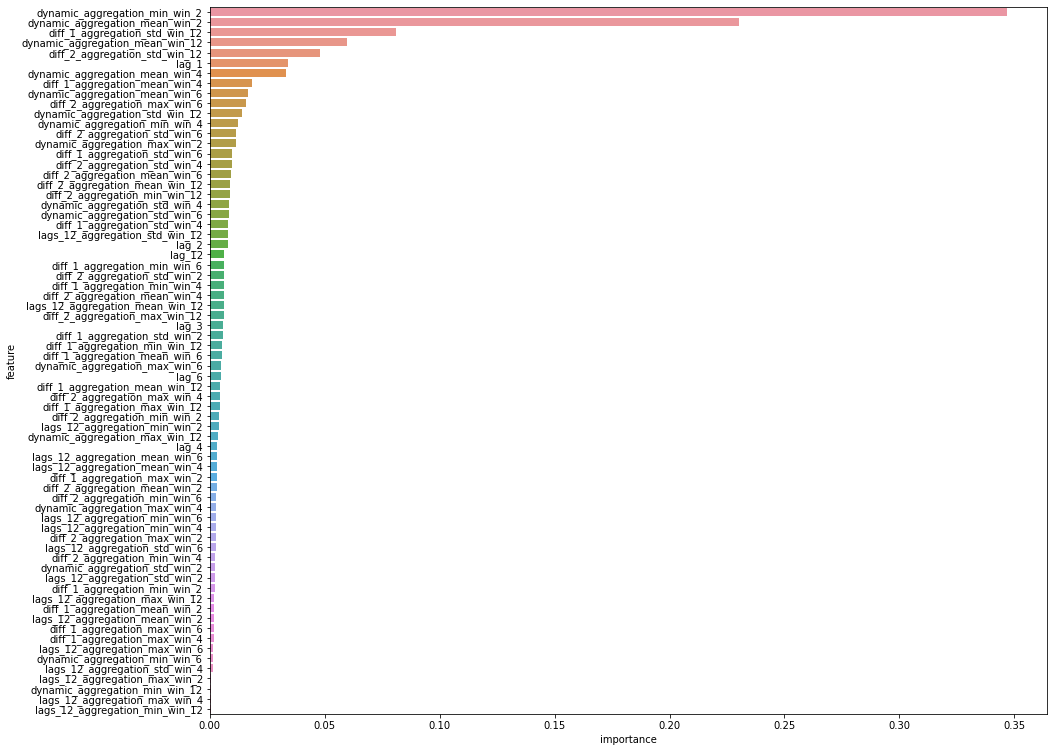

In [107]:
_, axs = plt.subplots(1, 1, figsize=(15, 13))

feature_impotrance_mean = (pd.DataFrame({
        'feature': train_x.columns, 
        'importance': perm_importance['importances_mean']
    })
    .set_index('feature')
    .sort_values('importance', ascending=False))
top_valid_features = feature_impotrance_mean.head(30)
tail_valid_features = feature_impotrance_mean.tail(30)

feature_impotrance_points = pd.DataFrame(perm_importance['importances'])
feature_impotrance_points.index = train_x.columns
feature_impotrance_points = feature_impotrance_points.unstack().reset_index().drop('level_0', axis=1).rename({'level_0': 'permutation', 'level_1': 'feature', 0:'importance'}, axis=1)

sns.barplot(data=feature_impotrance_mean.reset_index(), x='importance', y='feature', ax=axs)

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


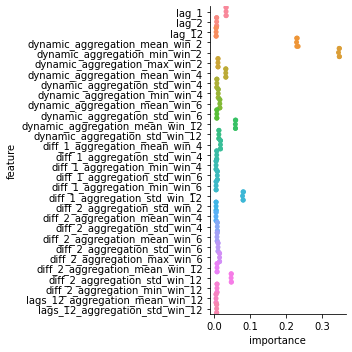

In [108]:
sns.catplot(data=feature_impotrance_points[feature_impotrance_points.feature.isin(top_valid_features.index)], kind='swarm', x='importance', y='feature')

In [109]:
top_train_x = train_x.loc[:, top_valid_features.index.values]
top_test_x = test_x.loc[:, top_valid_features.index.values]

tail_train_x = train_x.loc[:, tail_valid_features.index.values]
tail_test_x = test_x.loc[:, tail_valid_features.index.values]

## Basic models

### We gonna check 3 models (ElasticNet, Random Forest, XGBoost) 

1) Validation model

In [110]:
from sklearn.metrics import mean_squared_error as mse

class Validator:
    def __init__(self, model, **kwargs) -> None:
        self.model = model(**kwargs)
        self._context = {}

    def fit(self, x, y, trained_model=None):
        if trained_model is None:
            self.model.fit(x, y)
        else:
            self.model = trained_model

        return self.model

    def validate(self, x, y):
        
        predictions = self.model.predict(x)
        truth = y

        return mse(predictions, truth), predictions, truth

In [111]:
errors = {}

2) ElasticNet (CRUSHES ALL THE TIME) + ISSUE | Use Ridge instead

In [112]:
# lis = [[], []]

# for alpha_ in range(-8, 10):
#     print(alpha_)
#     validator_lin = Validator(Lasso, alpha=10**(alpha_))
    
#     validator_lin.fit(train_x, train_y)
#     err = validator_lin.validate(test_x, test_y)[0]

#     lis[0].append(alpha_)
#     lis[1].append(err)

# sns.scatterplot(*lis)

In [113]:
lin_validator = Validator(Ridge, alpha=1e-7)

lin_validator.fit(train_x, train_y)
errors['ridge'] = lin_validator.validate(test_x, test_y)
errors['ridge'][0]

with open('tmp/ridge_error.pkl', 'wb+') as writer:
        pickle.dump(errors['ridge'], writer)


3) Random Forest

In [114]:
lin_validator = Validator(RandomForestRegressor)

lin_validator.fit(train_x, train_y, trained_model=evaluation_forest)
errors['rfr'] = lin_validator.validate(test_x, test_y)
errors['rfr'][0]

20.039804626608504

4. XGBoost

In [115]:
from xgboost import XGBRegressor

In [116]:
# xgb_validator = Validator(XGBRegressor, n_estimators=100, learning_rate=0.1, n_jobs=4, max_depth=10, reg_alpha=1e-10)

# xgb_validator.fit(train_x, train_y)
# errors['xgb'] = xgb_validator.validate(test_x, test_y)
# errors['xgb'][0]

In [117]:
serieses = task_df['train'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts()

In [118]:
valid_idxs = serieses[serieses > 10].index

In [119]:
valid_idxs

Int64Index([ 367291, 1329082,  824592, 1228987, 1329078, 1228986,  824602,
            1220671, 1191151, 1064551,
            ...
             752905,  149671,  107339,  546751, 1058125,  180625, 1057342,
             152697,  488983, 1060624],
           dtype='int64', length=28238)

## Big object drop 

In [120]:
sampled_sets = {}

In [121]:
full_sampled_train = full_train[full_train.index.isin(valid_idxs)]

In [122]:
sampled_sets['train_x'] = full_sampled_train.drop(['target'], axis=1).fillna(0)
sampled_sets['train_y'] = full_sampled_train.loc[:, ['target']]
sampled_sets['validate_x'] = test_x
sampled_sets['validate_y'] = test_y

0
1
2
3
4
5
6
7
8
9


<AxesSubplot:>

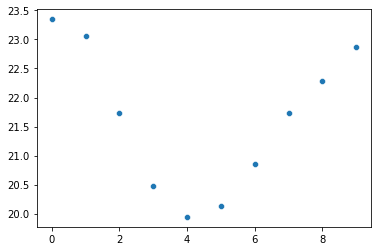

In [123]:
lis = [[], []]

for alpha_ in range(0, 10):
    print(alpha_)
    validator_lin = Validator(Ridge, alpha=10**(alpha_))
    
    validator_lin.fit(sampled_sets['train_x'], sampled_sets['train_y'])
    err = validator_lin.validate(test_x, test_y)[0]

    lis[0].append(alpha_)
    lis[1].append(err)

sns.scatterplot(*lis)

In [124]:
lin_validator = Validator(Ridge, alpha=1e4)

validator_lin.fit(sampled_sets['train_x'], sampled_sets['train_y'])
errors['ridge'] = validator_lin.validate(test_x, test_y)
errors['ridge'][0]

with open('tmp/ridge_error.pkl', 'wb+') as writer:
        pickle.dump(errors['ridge'], writer)

In [125]:
extended_train_x = train_x.reset_index().merge(task_df['idx'], on='id').set_index('id').drop(['item_name', 'shop_name', 'item_category_name'], axis=1)
extended_test_x = test_x.reset_index().merge(task_df['idx'], on='id').set_index('id').drop(['item_name', 'shop_name', 'item_category_name'], axis=1)

In [126]:
xgb_validator = Validator(XGBRegressor, booster='gbtree', n_estimators=100, learning_rate=0.1, n_jobs=4, max_depth=10)

xgb_validator.fit(extended_train_x, train_y)
errors['xgb'] = xgb_validator.validate(extended_test_x, test_y)
errors['xgb'][0]

19.326576164622693

In [127]:
with open('tmp/xgb_error.pkl', 'wb+') as writer:
        pickle.dump(errors['xgb'], writer)

<AxesSubplot:xlabel='importance', ylabel='feature'>

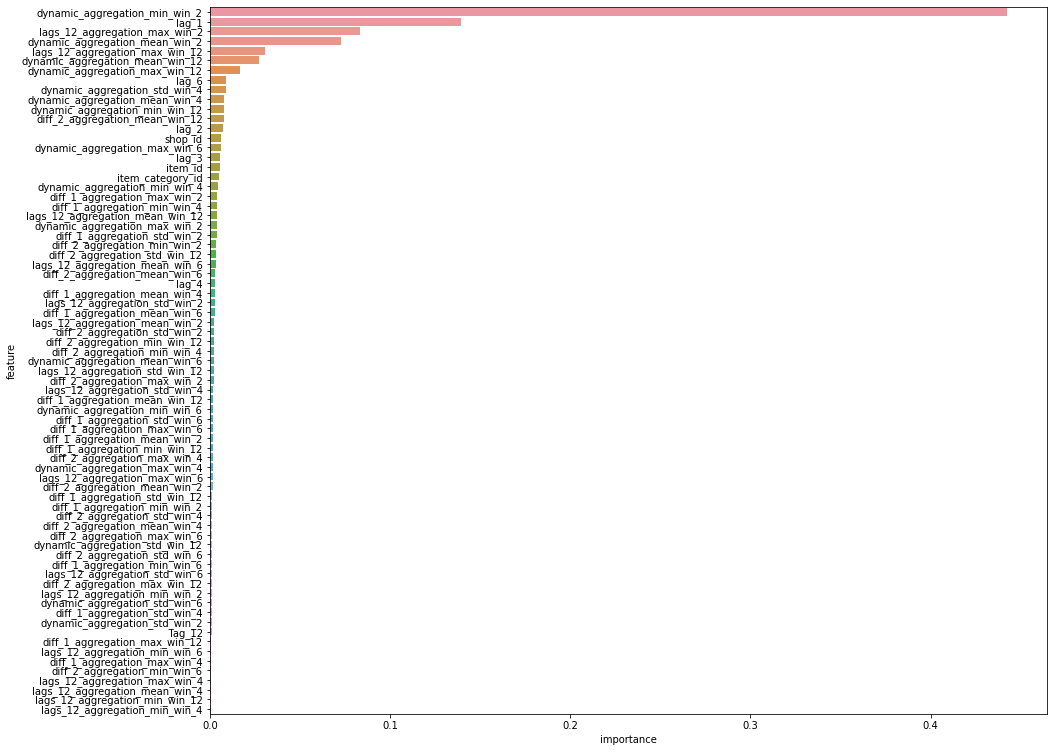

In [128]:
_, axs = plt.subplots(1, 1, figsize=(15, 13))

feature_impotrance_mean = (pd.DataFrame({
        'feature': extended_train_x.columns, 
        'importance': xgb_validator.model.feature_importances_
    })
    .set_index('feature')
    .sort_values('importance', ascending=False))
top_valid_features = feature_impotrance_mean.head(30)
tail_valid_features = feature_impotrance_mean.tail(30)

feature_impotrance_points = pd.DataFrame(perm_importance['importances'])
feature_impotrance_points.index = train_x.columns
feature_impotrance_points = feature_impotrance_points.unstack().reset_index().drop('level_0', axis=1).rename({'level_0': 'permutation', 'level_1': 'feature', 0:'importance'}, axis=1)

sns.barplot(data=feature_impotrance_mean.reset_index(), x='importance', y='feature', ax=axs)

## Make first submission!

In [129]:
extended_eval_x = eval_x.reset_index().merge(task_df['idx'], on='id').set_index('id').drop(['item_name', 'shop_name', 'item_category_name'], axis=1)
extended_submition_x = full_submition.reset_index().merge(task_df['idx'], on='id').set_index('id').drop(['item_name', 'shop_name', 'item_category_name'], axis=1)

In [130]:
xgb_validator = Validator(XGBRegressor, booster='gbtree', n_estimators=100, learning_rate=0.1, n_jobs=4, max_depth=10)

xgb_validator.fit(extended_eval_x, eval_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [131]:
extended_submition_x

,lag_1,lag_2,lag_3,lag_4,lag_6,lag_12,dynamic_aggregation_mean_win_2,dynamic_aggregation_std_win_2,dynamic_aggregation_min_win_2,dynamic_aggregation_max_win_2,...,lags_12_aggregation_std_win_6,lags_12_aggregation_min_win_6,lags_12_aggregation_max_win_6,lags_12_aggregation_mean_win_12,lags_12_aggregation_std_win_12,lags_12_aggregation_min_win_12,lags_12_aggregation_max_win_12,item_id,item_category_id,shop_id
id,,,,,,,,,,,,,,,,,,,,,
54,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.107730,-0.249574,-0.011493,-0.210179,0,40,54
114,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,0.195152,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.075256,-0.084625,-0.011493,-0.057439,2,40,54
174,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.042783,-0.027157,-0.011493,-0.057439,3,40,54
234,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.107730,-0.249574,-0.011493,-0.210179,4,40,54
294,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.107730,-0.249574,-0.011493,-0.210179,5,40,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330036,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.107730,-0.249574,-0.011493,-0.210179,22097,83,16
1330090,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,0.012566,-0.018398,0.004892,-0.075256,-0.084625,-0.011493,-0.057439,22098,83,10
1330142,-0.078757,-0.033209,-0.097019,-0.093756,-0.058521,-0.075469,-0.056408,-0.043456,-0.0419,-0.0519,...,-0.209078,-0.018398,-0.166612,-0.107730,-0.249574,-0.011493,-0.210179,22099,83,2


In [149]:
target = xgb_validator.model.predict(extended_submition_x)

In [146]:
submit = extended_submition_x.reset_index()[['id']]

In [147]:
submit['target'] = target

In [148]:
submit[submit.target < 0].target = 0
submit

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,id,target
0,54,-0.014239
1,114,-0.001170
2,174,-0.008944
3,234,-0.014239
4,294,-0.009171
...,...,...
422572,1330036,0.436736
422573,1330090,0.061619
422574,1330142,0.396637
422575,1330150,0.061619


In [155]:
submit.merge(MAP, on='id', how='right').drop(['shop_id', 'item_id'], axis=1).rename({'target':'item_cnt_month'}, axis=1).drop('id', axis=1).fillna(0)

,item_cnt_month,ID
0,0.429936,0
1,0.000000,1
2,0.713888,2
3,0.052003,3
4,0.000000,4
...,...,...
214195,0.274967,214195
214196,0.000000,214196
214197,0.033605,214197
214198,0.000000,214198


In [ ]:
sam